# CSC-7570-001 - AI Assisted Cyber Security

# ML-Based Assisted Access Control Action/Permission prediction

## **Task**

1. We aim to build a machine learning model that manages employee’s access to various resources in an organization. The model will improve access control decisions by accurately identifying authorized or unauthorized access and adapting access privileges based on historical patterns.
2. We will be using the Kaggle’s employee dataset to train and test the developed model. https://www.kaggle.com/datasets/lucamassaron/amazon-employee-access-challenge?resource=download
3. The goal is to replace the security policies with a trained machine learning model.

## 1.0 Import Libraries

In [39]:
# importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings


## 2.0 Load dataset

The data comes from Amazon Inc. collected from 2010-2011 (published on Kaggle platform). The training set consists of 32769 samples and the testing one of 58922 samples. The training set has one label attribute named **“ACTION”**, whose value **“1”** indicates an application is approved whereas **“0”** indicates rejection.

As predictors of this state, there are **eight (8) features**, indicating characteristics of the required resource anf the role and work group of the employee at Amazon requesting access

In [40]:
df = pd.read_csv("train.csv")
df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [41]:
df.columns

Index(['ACTION', 'RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2',
       'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY',
       'ROLE_CODE'],
      dtype='object')

In [42]:
# size of dataset
len(df)

32769

In [43]:
# check for empty records
df.isnull().sum()

ACTION              0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64

## 3.0 Data Visualization

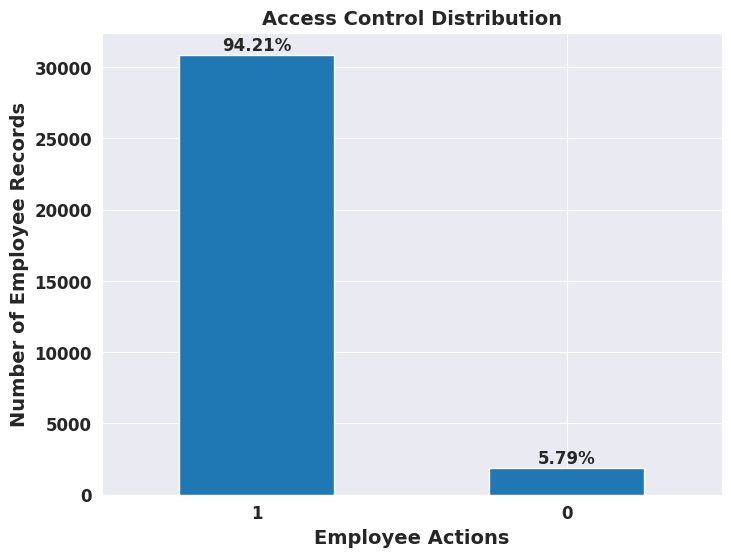

In [44]:

# Calculate class counts and percentages
sns.set_style("darkgrid")
class_counts = df['ACTION'].value_counts()
total_samples = len(df)
percentage_labels = [(count / total_samples) * 100 for count in class_counts]

# Create a bar chart to visualize the class distribution
plt.figure(figsize=(8, 6))
ax = class_counts.plot(kind='bar')
plt.title('Access Control Distribution', fontweight='bold', fontsize=14)
plt.xlabel('Employee Actions', fontweight='bold', fontsize=14)
plt.ylabel('Number of Employee Records', fontweight='bold', fontsize=14)
plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Add percentage labels on top of the bars (make them bold)
for i, count in enumerate(class_counts):
    ax.text(i, count, f'{percentage_labels[i]:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')


plt.show()


**Note:** Our raw dataset looks clean; we don't have any missing values; however, we might need to check for data inbalance.

1. The dataset is highly imbalance with 94.21% **1's** and 5.79% **0's**


## 4.0 Feature Engineering
1. Slit data in train-test
2. Scaling Data:  standardization

In [11]:
# importing relavant packages and classifiers from sklearn library

from sklearn.preprocessing import StandardScaler # for scaling
from sklearn.model_selection import train_test_split # for data splitting

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [12]:
# Separating the target label from the features
y = df["ACTION"] # labels
X = df.drop("ACTION", axis=1)  # training features


In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [45]:
#Scaling Dataset
scaler = StandardScaler()

# Fit and transform the scaler on the training set
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing set using the same scaler
X_test_scaled = scaler.transform(X_test)

#convert y_train to numpy array
y_train = np.array(y_train)

## Model Training

In [46]:
# building a general function for training the model
def model_train(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_tr = model.predict(X_train)
    y_pred = model.predict(X_test)


    print("--------------------Testing Performance----------------------")
    accuracy = accuracy_score(y_test, y_pred)
    print(accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    print("=======================================")
    print(" \n ")
    print("============Accuracy==========")
    print(accuracy_score(y_test, y_pred))

    conf_matrix = confusion_matrix(y_test, y_pred)
    print("============= Recall ===================")

    # Calculate recall
    TP = conf_matrix[1, 1]  # True Positives
    FN = conf_matrix[1, 0]  # False Negatives
    recall = TP / (TP + FN)

    print(f'Recall: {recall:.5f}')

    print("============= Precision ===================")

    # Calculate precision
    TP = conf_matrix[1, 1]  # True Positives
    FP = conf_matrix[0, 1]  # False Positives
    precision = TP / (TP + FP)

    print(f'Precision: {precision:.5f}')

    print("============= F1 Score ===================")

    # Calculate precision and recall
    TP = conf_matrix[1, 1]  # True Positives
    FP = conf_matrix[0, 1]  # False Positives
    FN = conf_matrix[1, 0]  # False Negatives

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall)

    print(f'F1 Score: {f1_score:.5f}')

    print("============= True Positive Rate (TPR) ===================")

    # Calculate True Positive Rate (TPR)
    TPR = recall

    print(f'True Positive Rate (TPR): {TPR:.5f}')

    print("============= False Positive Rate (FPR) ===================")

    # Calculate False Positive Rate (FPR)
    FP = conf_matrix[0, 1]  # False Positives
    TN = conf_matrix[0, 0]  # True Negatives
    FPR = FP / (FP + TN)

    print(f'False Positive Rate (FPR): {FPR:.5f}')

    return y_pred


## Evaluation Metrics

1. **Accuracy**: It measures the overall correctness of predictions made by a model, calculated as the ratio of correctly predicted instances to the total number of instances.

2. **Precision** is the ratio of true positive predictions to the total number of positive predictions. It measures the accuracy of positive predictions made by the model.

3. **Recall**: Recall, also known as **sensitivity** or **true positive rate**, assesses the model's ability to identify all relevant instances in the dataset. It's calculated as the ratio of true positives to the sum of true positives and false negatives.

4. **True Positive Rate (TPR):** TPR is also called **Recall** It represents the proportion of true positives among all actual positives in the dataset.

5. **False Positive Rate (FPR)**: FPR measures the rate at which the model incorrectly predicts positive outcomes when they are actually negative. It's calculated as the ratio of false positives to the sum of false positives and true negatives.

6. **F1 Score:** It combines the precision and recall scores of a model. The F1 score is calculated as the **harmonic mean of the precision and recall scores,** and a higher F1 score denotes a better-quality classifier.

## 5.1 Random Forest

* Random Forest: Random Forest builds a collection of decision trees, typically using the CART (Classification and Regression Trees) algorithm. It grows each tree independently and combines their predictions through bagging (bootstrap aggregating) and averaging.

In [47]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
y_pred2 = model_train(model, X_train, X_test, y_train, y_test)

--------------------Testing Performance----------------------
0.9453768690875801
              precision    recall  f1-score   support

           0       0.58      0.40      0.47       400
           1       0.96      0.98      0.97      6154

    accuracy                           0.95      6554
   macro avg       0.77      0.69      0.72      6554
weighted avg       0.94      0.95      0.94      6554

 
 
============Accuracy==========
0.9453768690875801
============= Recall ===================
Recall: 0.98083
============= Precision ===================
Precision: 0.96176
============= F1 Score ===================
F1 Score: 0.97120
============= True Positive Rate (TPR) ===================
True Positive Rate (TPR): 0.98083
============= False Positive Rate (FPR) ===================
False Positive Rate (FPR): 0.60000


In [18]:
#!pip3 install lightgbm

## 5.2  LightGBM

* LightGBM is a high-performance gradient boosting framework widely used in machine learning. It excels in speed, memory efficiency, and accuracy, making it a popular choice for tasks involving structured data and large datasets.

* LightGBM builds an ensemble of decision trees in a sequential manner. It minimizes a loss function by adding trees to the ensemble, with each tree correcting the errors made by the previous ones.

In [48]:
from lightgbm import LGBMClassifier
hyperparameters = {
    'learning_rate': 0.5,
    'max_depth': 10,
    'n_estimators': 300
}

# Create the LGBMClassifier with specified hyperparameters
model = LGBMClassifier(**hyperparameters)

#model = LGBMClassifier()
y_pred4 = model_train(model, X_train, X_test, y_train, y_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 24718, number of negative: 1497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1804
[LightGBM] [Info] Number of data points in the train set: 26215, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.942895 -> initscore=2.804069
[LightGBM] [Info] Start training from score 2.804069
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num